# Lets Run a Hybrid Search

In this notebook we'll learn about how to use a ML model to enrich our Icecat data with vectors, and then we'll balance a lexical search with a neural search.

### Prerequesites

Make sure to have Chorus OpenSearch Edition running. If you haven't the quickstart script has you covered. Run it in the home directory of the repository:

```
./quickstart.sh
```

We are making use of different features in OpenSearch, mainly:

* [Using pre-trained models in OpenSearch](https://opensearch.org/docs/latest/ml-commons-plugin/pretrained-models)
* [Hybrid search](https://opensearch.org/docs/latest/search-plugins/hybrid-search/)

In [1]:
import requests
import json
import mercury as mr
import time
import pandas as pd
from IPython.display import display, HTML, Image


app = mr.App(title="Let's Run a Hybrid Search", description="Demonstration of the process to set up hybrid search from scratch")

mercury.App

## Configure ML Commons plugin

The ML Commons plugin lets us use machine learning models during index and query time.

We configure it to be able to run on the same node that holds our indexed data (`"only_run_on_ml_node": "false"`). In a production setting we'd likely want to move machine learning workloads to dedicated ML nodes (`"only_run_on_ml_node": "true"`).

In [2]:
url = "http://localhost:9200/_cluster/settings"
headers = {
    'Content-Type': 'application/json'
}

payload = {
    "persistent": {
        "plugins": {
            "ml_commons": {
                "only_run_on_ml_node": "false",
                "model_access_control_enabled": "true",
                "native_memory_threshold": "99"
            }
        }
    }
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)

## Register a model group

First we check if a model group exists, and if not register a model group, then we will assign a model to this group. This is mainly a way to organise models in OpenSearch.

We need to grab the model_group_id from the OpenSearch response to register the model in the correct group.

Learn more about registering a model at https://opensearch.org/docs/latest/ml-commons-plugin/api/model-apis/register-model/.

In [3]:
# First see if we have registered the "NLP_model_group" or not

need_to_register_model_group = True

url = "http://localhost:9200/_plugins/_ml/model_groups/_search"

payload = {
  "query": {
    "match": {"name":"NLP_model_group"}
  },
  "size": 1000
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
#mr.JSON(response.json(), level=4)

if len(response.json()['hits']['hits']) > 0:
    model_group_id = response.json()['hits']['hits'][0]['_id']
    need_to_register_model_group = False
    
    print(f"Found Model Group ID {model_group_id}")

else:
    # We need to register the model group
    url = "http://localhost:9200/_plugins/_ml/model_groups/_register"
    
    payload = {
      "name": "NLP_model_group",
      "description": "A model group for NLP models"
    }
    
    
    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    
    mr.JSON(response.json(), level=4)
    
    model_group_id = response.json()['model_group_id']
    
    print(f"Created Model Group ID {model_group_id}")

Created Model Group ID suaXQ5IBZTHxIzZB40jL


## Register the model to the model group
Under the covers we are downloading from HuggingFace 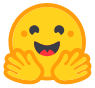 the model and saving it into our cluster. This can take some time!

We are using the model `all-MiniLM-L6-v2`, one of several options hosted on HuggingFace to choose from in OpenSearch. You can find a list of supported pretrained models in the [OpenSearch docs](https://opensearch.org/docs/latest/ml-commons-plugin/pretrained-models#supported-pretrained-models).

Note that `all-MiniLM-L6-v2` uses 384 dimensions. This will become important later.

In [4]:
# First see if we have registered the model "all-MiniLM-L6-v2" or not

need_to_register_model = True

url = "http://localhost:9200/_plugins/_ml/models/_search"

payload = {
  "query": {
    "bool": {
      "must_not": {
        "exists": {
          "field": "chunk_number"
        }
      },
        "must": {
        "match": {
          "name": "huggingface/sentence-transformers/all-MiniLM-L6-v2"
        }
      },     
    }
  },
  "size": 1000
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
#mr.JSON(response.json(), level=4)

if len(response.json()['hits']['hits']) > 0:
    model_id = response.json()['hits']['hits'][0]['_id']
    need_to_register_model = False
    
    print(f"Found Model ID {model_id}")

else:
    url = "http://localhost:9200/_plugins/_ml/models/_register"
    
    # Previously had huggingface/sentence-transformers/msmarco-distilbert-base-tas-b
    
    payload = {
      "name": "huggingface/sentence-transformers/all-MiniLM-L6-v2",
      "version": "1.0.1",
      "model_group_id": model_group_id,
      "model_format": "TORCH_SCRIPT"
    }


    response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
    mr.JSON(response.json(), level=4)
    task_id = response.json()['task_id']

## Check status of registering model

Since downloading and registering the model may take a while we periodically check the status of this operation and wait for it to complete before we proceed.

In [5]:
if need_to_register_model:
    url = f"http://localhost:9200/_plugins/_ml/tasks/{task_id}"
    
    max_attempts = 10
    attempts = 0
    
    state = None
    while state != 'COMPLETED' and attempts < max_attempts:
        attempts = attempts + 1
        time.sleep(5) # wait five second and then check again.  We are downloading msmarco model from huggingface.
        response = requests.request("GET", url, headers=headers)
        #mr.JSON(response.json(), level=4)
        print(response.json()['state'])
        state = response.json()['state']
        
    
    model_id = response.json()['model_id']
    
    print(f"Created Model ID {model_id}")

CREATED
COMPLETED
Created Model ID tOaXQ5IBZTHxIzZB50hO


## Deploy the model
Under the covers we are downloading and deploying into OpenSearch pytorch4j!

In [6]:
if need_to_register_model:
    url = f"http://localhost:9200/_plugins/_ml/models/{model_id}/_deploy"
    
    response = requests.request("POST", url, headers=headers)
    mr.JSON(response.json(), level=4)
    deploy_model_task_id = response.json()['task_id']

## Check the status

We need to check the status again before proceeding to make sure it's available on our OpenSearch node.

In [7]:
if need_to_register_model:
    url = f"http://localhost:9200/_plugins/_ml/tasks/{deploy_model_task_id}"
    
    max_attempts = 10
    attempts = 0
    
    state = None
    while state != 'COMPLETED' and attempts < max_attempts:
        attempts += 1
        time.sleep(5) # wait five second and then check again.  Deploying the model can take a while
        response = requests.request("GET", url, headers=headers)
        #mr.JSON(response.json(), level=4)
        print(response.json()['state'])
        state = response.json()['state']
        
        
    
    model_id = response.json()['model_id']
    
    print(f"Finished Deploying Model ID {model_id}")

RUNNING
RUNNING
RUNNING
COMPLETED
Finished Deploying Model ID tOaXQ5IBZTHxIzZB50hO


### Test out using the Model to create sentence embeddings

To test the model to get a sense what it's doing behind the scenes. We can do that without actually indexing or querying data.

We use the `_predict` endpoint and the registered model to create embeddings for a textual input. Embeddings are numerical representation of text that machines can work with. These embeddings are the actual things we store when we do neural search. Another word for embedding is vector.
We also create embeddings for the query and then the search engine is able to calculate the distance between the indexed vector and the query vector to see how similar they are.

For now we'll only look at how these embeddings look like for an example string `today is sunny`.

Feel free to expand the returned data by hitting the + symbol in the response.
You will notice that the returned data has 384 items - the exact number of dimensions the model has. The second time we encounter this number!

In [8]:
url = f"http://localhost:9200/_plugins/_ml/_predict/text_embedding/{model_id}"

payload = {
  "text_docs":[ "today is sunny"],
  "return_number": True,
  "target_response": ["sentence_embedding"]
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=5)

## Create an Ingest pipeline
Here we are creating an embedding using our model on the title field called `title_embedding` that we can refer to later. During index time the content of the field `title` is used and embeddings are generated by the registered model.

The generated embeddings will be stored in the field `title_embedding`.


Learn more at https://opensearch.org/docs/latest/ingest-pipelines/processors/text-embedding/.

In [9]:
url = "http://localhost:9200/_ingest/pipeline/nlp-ingest-pipeline"

payload = {
  "description": "A text embedding pipeline",
  "processors": [
    {
      "text_embedding": {
        "model_id": model_id,
        "field_map": {
          "title": "title_embedding"
        }
      }
    }
  ]
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)


## Specify our weighting for keyword and neural in Hybrid

Hybrid search with OpenSearch is linearly combining keyword search (e.g. match queries) with neural search (transforming queries to vector embeddings by using machine learning models). This combination is configured in a search pipeline. It defines the post processing of the result sets for keyword and neural search by normalizing the scores of each and then combining them with one of currently three available techniques (arithmetic, harmonic, geometric).

By specifiying the `weights` we tell OpenSearch how important keyword matches are compared to neural matches. This can be any float between 0 and 1.0 with 0 meaning we don't care for keywords at all and 1.0 meaning we don't want neural search to play a role at all.

## Configure Search Pipelines
Configure a search pipeline to hold the model_id and apply it to our title_embeddings field.    
Learn more at https://opensearch.org/docs/latest/search-plugins/semantic-search/#setting-a-default-model-on-an-index-or-field  It also applies our balancing weights between keyword and neural.  Here we are using the `normalization-processor` to merge documents returned from the keyword search with documents returned from the neural search.  See https://opensearch.org/docs/latest/search-plugins/search-pipelines/normalization-processor/ for more info.

In [12]:
url = "http://localhost:9200/_search/pipeline/hybrid-search-pipeline"

print(f"Setting default model id to: {model_id}")
payload = {
  "request_processors": [
    {
      "neural_query_enricher" : {
        "description": "Sets the default model ID at index and field levels",
        "default_model_id": model_id,
        "neural_field_default_id": {
           "title_embeddings": model_id
        }
      }
    }
  ],
  "phase_results_processors": [
    {
      "normalization-processor": {
        "normalization": {
          "technique": "min_max"
        },
        "combination": {
          "technique": "arithmetic_mean",
          "parameters": {
            "weights": [
              0.3,
              0.7
            ]
          }
        }
      }
    }
  ]    
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)


Setting default model id to: tOaXQ5IBZTHxIzZB50hO


### Configure a search pipeline to perform only neural search


In [13]:
url = "http://localhost:9200/_search/pipeline/neural-search-pipeline"

payload = {
  "description": "Neural Only Search",
  "request_processors": [
    {
      "neural_query_enricher" : {
        "description": "Sets the default model ID at index and field levels",
        "default_model_id": model_id,
        "neural_field_default_id": {
           "title_embeddings": model_id
        }
      }
    }
  ]
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)

# Now it's time to reindex

## Augment the existing ecommerce schema
Read in the existing ecommerce schema and augment it with the knn settings and the new ingestion pipeline for generating embeddings.
This ensures that when we reindex data, we are running the `nlp-ingest-pipeline` to get the embeddings on the title field.


Note the number of dimensions is set to 384, the third time we encounter the number. This makes sure we can store the embeddings generated by the model.

In [14]:
# Specify the path to your JSON file
json_file_path = '../opensearch/schema.json'

with open(json_file_path, 'r') as file:
    schema = json.load(file)

# Add the new setting to the settings hash
new_settings = {
  "settings": {
    "index.knn": True,
    "default_pipeline": "nlp-ingest-pipeline"
  }
}

new_mappings = {
  "mappings": {
    "properties": {
      "title_embedding": {
        "type": "knn_vector",
        "dimension": 384,
        "method": {
          "engine": "lucene",
          "space_type": "l2",
          "name": "hnsw",
          "parameters": {}
        }
      }      
    }
  }
}

settings = {**new_settings['settings'], **schema['settings']}
properties = {**new_mappings['mappings']['properties'], **schema['mappings']['properties']}

#mr.JSON(properties)

schema['settings'] = settings
schema['mappings']['properties'] = properties
mr.JSON(schema, level=2)

## Create a new `ecommerce-hybrid` index that includes both keywords and embeddings
This new index will support neural only as well as hybrid use cases.

In [15]:
url = "http://localhost:9200/ecommerce-hybrid"

payload = schema
response = requests.request("DELETE", url, headers=headers)

response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)

## Reindex Ecommerce with Embeddings
The call to `_reindex` is takes just a few seconds without embeddings, but WITH embeddings it can take two minutes or more to complete.  We get back a task id and then poll for completion.

In [17]:
url = "http://localhost:9200/_reindex?wait_for_completion=false"

payload = {
  "source": {
    "index": "ecommerce-keyword"
  },
  "dest": {
    "index": "ecommerce-hybrid"
  }
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=1)

reindex_task_id = response.json()['task']

In [18]:
url = f"http://localhost:9200/_tasks/{reindex_task_id}"

max_attempts = 100
attempts = 0

state = None
while state != 'COMPLETED' and attempts < max_attempts:
    attempts += 1
    time.sleep(5) # wait five seconds and then check again.  Reindexing with embeddings can take a while
    response = requests.request("GET", url, headers=headers)
    #mr.JSON(response.json(), level=4)
    
    if response.json()['completed'] == True:
        state = 'COMPLETED'
    else:
        #mr.JSON(response.json(), level=1)
        print(f" {response.json()['task']['status']['created']}")

print(f"Continuing on with state {state}")

 0
 1000
 2000
 3000
 4000
 5000
 6000
 8000
 8000
 9000
 10000
 12000
 13000
 14000
 15000
 16000
 17000
 18000
Continuing on with state COMPLETED


## Establish an Alias for ecommerce_hybrid index
The front end app just talks to a index called `ecommerce`, under the covers that is a alias.  So we are updating it.

In [19]:
url = "http://localhost:9200/_aliases"

payload = {
  "actions": [
      {
      "remove": {
        "index": "ecommerce-keyword",
        "alias": "ecommerce"
      }
    },
    {
      "add": {
        "index": "ecommerce-hybrid",
        "alias": "ecommerce"
      }
    }    
  ]
}


response = requests.request("POST", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=1)


## Just a Neural Search

In [20]:
url = "http://localhost:9200/ecommerce/_search?search_pipeline=neural-search-pipeline"

payload = {
  "_source": {
    "exclude": [
      "title_embedding"
    ]
  },
  "query": {
    "hybrid": {
      "queries": [
        {
          "neural": {
            "title_embedding": {
              "query_text": "Hi world",
              "k": 5
            }
          }
        }
      ]
    }
  }
}


response = requests.request("GET", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=3)

## Combining neural and lexical match query

Notice that we add to the mix both a lexical (_match_) and a neural query.  They are blended by the `hybrid-search-pipeline` that we reference.

You can play with the weighting between keyword and neural by playing with the slider, which updates the pipeline settings used by the queries.

In [21]:
keyword_weight = mr.Slider(value=0.3, min=0, max=1.0, label="Keyword Weight", step=.05)

mercury.Slider

In [22]:
neural_weight = round(1.0 - keyword_weight.value, 2)
print(f"Keyword Weight is {keyword_weight.value} and Neural Weight is {neural_weight}")

Keyword Weight is 0.3 and Neural Weight is 0.7


In [23]:
url = "http://localhost:9200/_search/pipeline/hybrid-search-pipeline"

print(f"Setting default model id to: {model_id}")
payload = {
  "request_processors": [
    {
      "neural_query_enricher" : {
        "description": "Sets the default model ID at index and field levels",
        "default_model_id": model_id,
        "neural_field_default_id": {
           "title_embeddings": model_id
        }
      }
    }
  ],
  "phase_results_processors": [
    {
      "normalization-processor": {
        "normalization": {
          "technique": "min_max"
        },
        "combination": {
          "technique": "arithmetic_mean",
          "parameters": {
            "weights": [
              keyword_weight.value,
              neural_weight
            ]
          }
        }
      }
    }
  ]    
}


response = requests.request("PUT", url, headers=headers, data=json.dumps(payload))
mr.JSON(response.json(), level=4)


Setting default model id to: tOaXQ5IBZTHxIzZB50hO


To change the _query_ edit the text box and then run the next cell BELOW the text box to read the value in and then progress on. The default query demonstrates neural's support for mispellings.

In [28]:
query = mr.Text(value="Toner catrdge from leximark brand", label="Query", rows=1)

mercury.Text

In [25]:
query_text = query.value
print(f"Going to search for {query_text}")

Going to search for printer toner


In [26]:
url = "http://localhost:9200/ecommerce-hybrid/_search?search_pipeline=hybrid-search-pipeline"

payload = {
  "_source": {
    "excludes": [
      "title_embedding"
    ]
  },
  "query": {
    "hybrid": {
      "queries": [
        {
          "match": {
            "title_text": {
              "query": query.value
            }
          }
        },
        {
          "neural": {
            "title_embedding": {
              "query_text": query.value,
              "k": 50
            }
          }
        }
      ]
    }
  }
}


response = requests.request("GET", url, headers=headers, data=json.dumps(payload))
mr.Confetti()
data = response.json()
#mr.JSON(response.json(), level=5)
#print(response.json())
# Extract the 'hits' list from the nested structure
hits = data['hits']['hits']

titles = []
img_lows = []

for hit in hits:
    source = hit['_source']
    titles.append(source.get('title', 'N/A'))  # Use 'N/A' if title is missing
    img_lows.append(source.get('img_low', 'N/A'))  # Use 'N/A' if img_low is missing



# Create a DataFrame
df = pd.DataFrame({
    'title': titles,
    'img_low': img_lows
})


# Display the DataFrame
#print(df)

# Function to create HTML for each row
def create_html(row):
    return f'<tr><td>{row["title"]}</td><td><img src="{row["img_low"]}" width="100"></td></tr>'

# Create HTML table
html_table = f"""
<table>
    <tr>
        <th>Title</th>
        <th>Image</th>
    </tr>
    {''.join(df.apply(create_html, axis=1))}
</table>
"""

# Display the HTML table
display(HTML(html_table))



Title,Image
Verbatim HP LJ9000 30000 Page Toner,
Brother Black Toner Cartridge,
Lexmark C540X75G toner collector 36000 pages,
Lexmark C930X76G toner collector 30000 pages,
Brother Cyan Toner Cartridge,
Lexmark 10B3100 toner collector,
Xerox 008R12896 toner cartridge,
Lexmark 20K0505 toner collector 12000 pages,
Brother Black Toner Toner Cartridge Original,
"Xerox WorkCentre 4250 / 4260 Toner Cartridge (25,000 pages) - 106R01409",


## Verify Multi-Search and Pipeline compatiblity

Starting with OpenSearch 2.18 search pipelines can be specified per query in Multi-Search.   This validates it works.   The ReactiveSearch frontend used in Chorus relies on Multi-Search to send it's queries.

In [27]:
url = "http://localhost:9200/ecommerce/_msearch"

# We have weird JSONL formatting that the Multi Search uses, so not JSON!
payload = '{ "index": "ecommerce"}\n{ "query": { "match_all": {} }, "from": 0, "size": 10}, "search_pipeline":"neural-search-pipeline" \n'


response = requests.request("GET", url, headers=headers, data=payload)
mr.JSON(response.json(), level=5)
